#ENT DISEASES IDENTIFICATION USING VOICE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import re
import glob
import pandas as pd
import librosa
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score


#/content/drive/MyDrive/sbvoiceDataset/Dataset/female_Hyperfunktionelle_Dysphonie/1037-a_h.wav


## Extract Features
Here we will be using Mel-Frequency Cepstral Coefficients(MFCC) from the audio samples. The MFCC summarises the frequency distribution across the window size, so it is possible to analyse both the frequency and time characteristics of the sound. These audio representations will allow us to identify features for classification.

In [ ]:
def features_extractor_MFCC(file_name):
    audio, sample_rate = librosa.load(file_name)
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

    return mfccs_scaled_features

def features_extractor_lpcc(file_name):
    audio, sample_rate = librosa.load(file_name)
    lpc_coefficients = librosa.lpc(audio, order=12)
    epsilon = 1e-10
    powerspectrum = np.abs(np.fft.fft(lpc_coefficients)) ** 2
    # transformed_features = np.sqrt(np.maximum(np.max(pq\) + 1 - mfccs_feature, 0))
    lpc_coefficients_offset = np.maximum(powerspectrum, epsilon)
    lpcc_features = np.fft.irfft(np.log(lpc_coefficients_offset))

    return lpcc_features
#example:
audio_file_path="/content/drive/MyDrive/sbvoiceDataset/Dataset/female_Hyperfunktionelle_Dysphonie/1037-a_h.wav"
mfccs = features_extractor_MFCC(audio_file_path)
lpccs=features_extractor_lpcc(audio_file_path)
print(mfccs.shape,lpccs.shape)

(40,) (24,)


In [ ]:
def features_extractor_currect_folder(foldername,label):
  label_feature=[]
  for filename in tqdm(glob.glob(foldername+'/*.wav')):
    data=features_extractor_MFCC(filename)
    label_feature.append([data,label])

  return label_feature

In [ ]:
label_features=[]
folder_path='/content/drive/MyDrive/sbvoiceDataset/Dataset'
folders_labels=[[flder, 1 if 'healthy' in flder[len(folder_path):] else 0 ]for flder in glob.glob(folder_path+'/*')]
# print(_labels)


for folder , label in (folders_labels):
  label_features.extend(features_extractor_currect_folder(folder,label))





In [ ]:
folder_path='/content/drive/MyDrive/sbvoiceDataset/Dataset'
folders_labels=[[flder, 1 if 'healthy' in flder[len(folder_path):] else 0 ]for flder in glob.glob(folder_path+'/*')]
s=folders_labels[0][0]
print(s)
xs=s.replace('sbvoiceDataset','aug_sbvoiceDataset')
print(xs)

/content/drive/MyDrive/sbvoiceDataset/Dataset/female_Hyperfunktionelle_Dysphonie
/content/drive/MyDrive/aug_sbvoiceDataset/Dataset/female_Hyperfunktionelle_Dysphonie


In [ ]:
# prompt: replace substring in string with new substring in that string using inbuilt string

s = s.replace('Dataset', 'Data')
print(s)


/content/drive/MyDrive/sbvoiceData/Data/female_Hyperfunktionelle_Dysphonie


In [ ]:
label_features_df=pd.DataFrame(label_features,columns=['feature','class'])
label_features_df.tail()

,feature,class


In [ ]:
path="/content/drive/MyDrive/sbvoiceDataset/"
# label_features_df.to_json(path+'processed_data.json')

In [ ]:
# X=np.array(label_features_df['feature'].tolist())
# Y=np.array(label_features_df['class'].tolist())

# print(len(X[-1]))
# print(X.shape,Y.shape)

## TRAINING THE MODEL
Read and Spilit Data in two TRAIN and TEST SET.

In [ ]:
label_features_df_saved=pd.read_json(path+'processed_data.json')
label_features_df_saved.tail()

X=np.array(label_features_df_saved['feature'].tolist())
Y=np.array(label_features_df_saved['class'].tolist())



In [ ]:
print((X[0][1]))
print(X.shape,Y.shape)
Y=Y.reshape((-1,1))
print(X.shape,Y.shape)


-8.3904752731
(2878, 40) (2878,)
(2878, 40) (2878, 1)


In [ ]:
print(Y[-1])

[1]


In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=0)

print(X_train.shape,X_test.shape)
print(Y_train.shape,Y_test.shape)



(2302, 40) (576, 40)
(2302, 1) (576, 1)


Traing _model

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [ ]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.2))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.2))

###4th layer
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.2))

###final layer
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [ ]:
model.summary()

In [ ]:
model.compile(loss='BinaryCrossentropy',metrics=['accuracy'],optimizer='adam')

In [ ]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath=path+'/saved_models/dieases_classification.hdf5',
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, Y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, Y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

In [ ]:
!pip install --upgrade tensorflow

In [ ]:
!pip install scikeras

In [ ]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score

In [ ]:
# from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
# # from tensorflow.keras.models import load_model
# # model_path = path + '/saved_models/dieases_classification.hdf5'
# from scikeras.wrappers import KerasRegressor
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline

def create_model():
    model=Sequential()
    ###first layer
    model.add(Dense(100,input_shape=(40,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    ###second layer
    model.add(Dense(200))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    ###third layer
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    ###4th layer
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    ###final layer
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='BinaryCrossentropy',metrics=['accuracy'],optimizer='adam')
    return model
# # Load the saved model
# loaded_model = load_model(model_path)
# test_accuracy=loaded_model.evaluate(X_test,Y_test,verbose=0)
# print(test_accuracy[1])
estimator = KerasClassifier(build_fn=create_model, epochs=100, batch_size=15, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Adjust the number of splits as needed
results = cross_val_score(estimator, X_train, Y_train, cv=kfold,scoring='accuracy')

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

In [ ]:
results.mean()

0.7676063378289163

In [ ]:
Dieases_audio_file_path="/content/drive/MyDrive/sbvoiceDataset/Dataset/female_Hyperfunktionelle_Dysphonie/1037-a_h.wav"

prediction_feature_dieases=features_extractor_MFCC(Dieases_audio_file_path)
prediction_feature_dieases=prediction_feature_dieases.reshape(1,-1)

print(prediction_feature_dieases.shape)
# model.predict_classes(prediction_feature)

healthy_audio_file_path="/content/drive/MyDrive/sbvoiceDataset/Dataset/female_healthy/1-a_h.wav"
prediction_feature_healthy=features_extractor_MFCC(healthy_audio_file_path)
prediction_feature_healthy=prediction_feature_healthy.reshape(1,-1)


In [ ]:
yhat1 = model.predict(prediction_feature_dieases)
yhat2 = model.predict(prediction_feature_healthy)

# converting logits to classes
yhat1 = [1 if prediction > 0.5 else 0 for prediction in yhat1]
yhat2 =[1 if prediction > 0.5 else 0 for prediction in yhat2]

print(yhat1,yhat2)

In [ ]:
path="/content/drive/MyDrive/sbvoiceDataset/"
label_features_df_saved=pd.read_json(path+'processed_data.json')
label_features_df_saved.tail()

X=np.array(label_features_df_saved['feature'].tolist())
Y=np.array(label_features_df_saved['class'].tolist())

In [ ]:
df_X = pd.DataFrame(X, columns=[f'X_{i}' for i in range(40)])

# Create a DataFrame from the 2D array Y
df_Y = pd.DataFrame(Y, columns=['Y'])

# Concatenate the two DataFrames along the columns (axis=1)
df_result = pd.concat([df_X, df_Y], axis=1)
df_result.head()

,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,X_31,X_32,X_33,X_34,X_35,X_36,X_37,X_38,X_39,Y
0,-271.639832,-8.390475,26.312756,70.594482,-1.518174,-23.457338,-10.246496,10.064326,-38.681492,-6.614583,...,-15.436118,-1.638905,14.780800,13.691861,-6.182680,-20.629036,-3.667800,16.829103,12.360208,0
1,-229.541138,155.062393,5.250329,-19.146978,-27.645874,4.789426,5.181211,3.145025,-2.928293,-9.532020,...,1.387780,-12.593229,-4.477371,-5.315466,-5.926450,-11.024710,-2.433976,-7.693701,-12.677904,0
2,-287.905609,107.016525,35.347649,76.809212,24.339685,-44.579643,-0.316843,-5.240526,-20.110870,-3.314139,...,-6.920123,1.020935,-10.559141,-6.996330,-5.168002,-13.878583,-5.874880,-13.556870,-0.457737,0
3,-169.492966,92.856682,-29.368196,-31.939228,-38.718842,-9.115637,-1.346908,-1.813794,-19.897358,6.806201,...,6.260107,-14.329452,-0.320888,8.674538,11.464392,5.933794,-6.063705,-11.656724,3.798363,0
4,-252.985764,55.902462,43.445042,75.801971,16.724638,-25.247791,1.106061,6.059499,-33.704525,-0.947820,...,31.855537,24.148304,24.610531,14.486822,1.745655,-5.527664,-0.218292,0.172574,12.650428,0


In [ ]:
import seaborn as sns

# sns.pairplot(df_sample,hue="Y")
sns.pairplot(df_result.sample(1600), diag_kind='kde')

#AUDIO AUGUMENTATION

In [ ]:
audio_file_path="/content/drive/MyDrive/sbvoiceDataset/Dataset/female_Hyperfunktionelle_Dysphonie/1037-a_h.wav"
librosa_audio_data,librosa_sample_rate=librosa.load(audio_file_path)

print(librosa_sample_rate)

22050


In [ ]:
audio_file_path="/content/drive/MyDrive/sbvoiceDataset/Dataset/female_Hyperfunktionelle_Dysphonie/1037-a_h.wav"
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 27)


In [ ]:
print(librosa_audio_data,librosa_sample_rate)

[0.05311411 0.11161216 0.15054351 ... 0.13371423 0.14862993 0.15350561] 22050


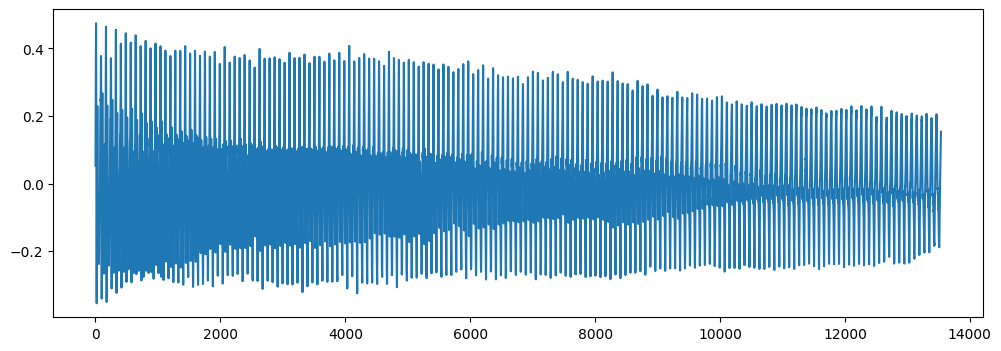

In [ ]:
###plot the librosa audio data
# Original audio with 1 channel
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_data)

In [ ]:
!pip install audiomentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 1.4 MB/s eta 0:00:00


In [ ]:
# prompt: use compose of audio tranformatio both wav form and spectogram based seperately using lib audiomentation

import librosa
import numpy as np
from audiomentations import Compose, AddGaussianNoise, TimeStretch, SpecCompose, SpecChannelShuffle, SpecFrequencyMask


def audio_augmentation_wav(audio_file_path):
    # Load the audio data
    audio, sr = librosa.load(audio_file_path)

    # Create a Compose object with various audio transformations
    transform = Compose([
       AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.085,p=1),
       TimeStretch(min_rate=0.8, max_rate=1.15, p=0.8),
    ])

    # Apply the transformations to the audio data
    augmented_audio = transform(audio, sr)

    return augmented_audio,sr


#example :augmented_mfccs=audio_augmentation_spec(mfccs) extract mfcc without normalizing it (2-D array)

def audio_augmentation_spec(spec):
    # Create a Compose object with various spectrogram transformations
    transform = SpecCompose([
        SpecFrequencyMask(p=0.6),
    ])

    # Apply the transformations to the spectrogram
    augmented_spec = transform(spec)

    return augmented_spec




Original MFCCs shape: (40, 27)
Augmented MFCCs shape: (40, 27)


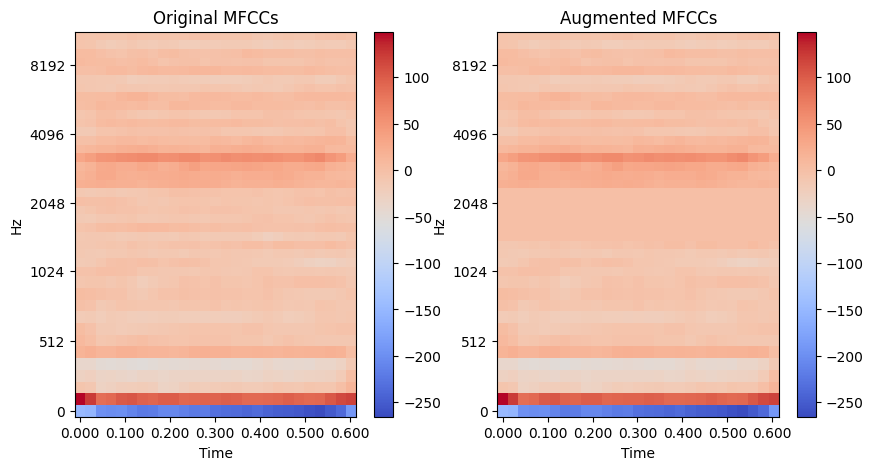

In [ ]:
# prompt: write to augment mfcss variable using audio_augmentation spec  and print spec before and after augmentation

import matplotlib.pyplot as plt

augmented_mfccs=audio_augmentation_spec(mfccs)

# Print the original and augmented MFCCs
print("Original MFCCs shape:", mfccs.shape)
print("Augmented MFCCs shape:", augmented_mfccs.shape)

# Plot the original and augmented MFCCs
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
librosa.display.specshow(mfccs, x_axis='time', y_axis='mel', sr=librosa_sample_rate)
plt.title('Original MFCCs')
plt.colorbar()

plt.subplot(1, 2, 2)
librosa.display.specshow(augmented_mfccs, x_axis='time', y_axis='mel', sr=librosa_sample_rate)
plt.title('Augmented MFCCs')
plt.colorbar()
plt.show()


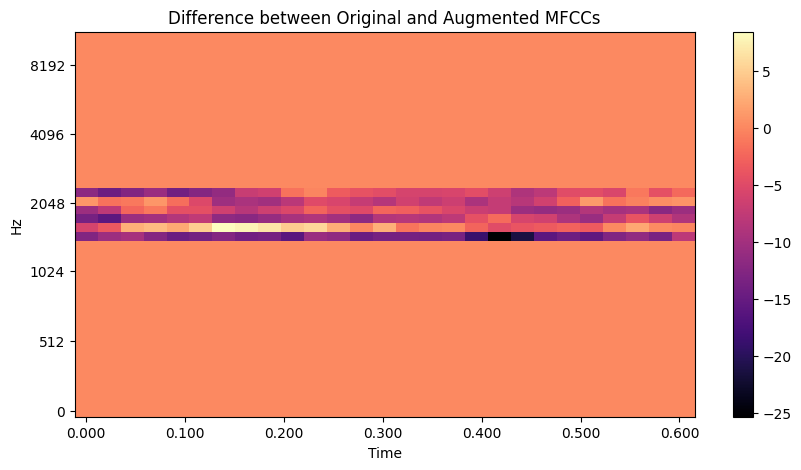

In [ ]:
# prompt: plot that difference of mfccs and augmented_mfccs

import matplotlib.pyplot as plt

# Calculate the difference between the original and augmented MFCCs
diff_mfccs = mfccs - augmented_mfccs

# Plot the difference
plt.figure(figsize=(10, 5))
librosa.display.specshow(diff_mfccs, x_axis='time', y_axis='mel', sr=librosa_sample_rate)
plt.title('Difference between Original and Augmented MFCCs')
plt.colorbar()
plt.show()


In [ ]:
# prompt: save augmented wav voice

import librosa
import soundfile as sf
# Define the original audio file path and sample rate
original_audio_file_path = "/content/drive/MyDrive/sbvoiceDataset/Dataset/female_Hyperfunktionelle_Dysphonie/1037-a_h.wav"
sample_rate = 22050

# Generate augmented audio data using the function
augmented_audio,sr = audio_augmentation_wav(original_audio_file_path)

# Define the augmented audio file path
augmented_audio_file_path = "/content/drive/MyDrive/aug_sbvoiceDataset/Dataset/female_Hyperfunktionelle_Dysphonie/augmented_1037-a_h3.wav"

# Save the augmented audio data to a new file
os.makedirs(os.path.dirname(augmented_audio_file_path), exist_ok=True)
sf.write(augmented_audio_file_path, augmented_audio, sr)


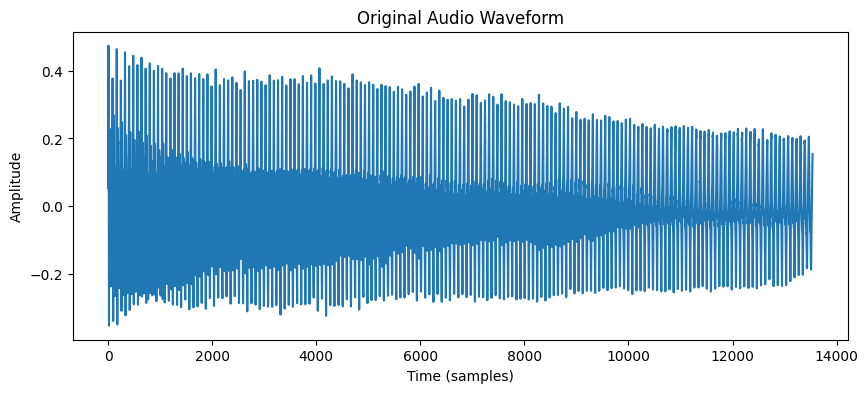

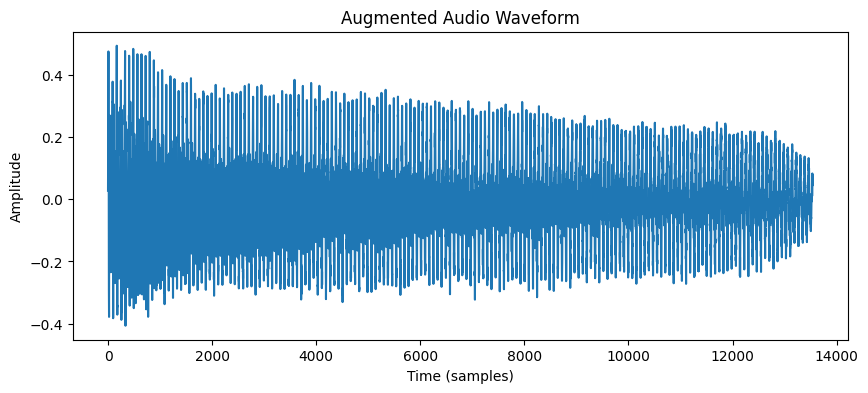

In [ ]:
# prompt: print wav form of both voice

import matplotlib.pyplot as plt
import librosa
import soundfile as sf

# Load the original and augmented audio files
original_audio_file_path = "/content/drive/MyDrive/sbvoiceDataset/Dataset/female_Hyperfunktionelle_Dysphonie/1037-a_h.wav"
augmented_audio_file_path = "/content/drive/MyDrive/aug_sbvoiceDataset/Dataset/female_Hyperfunktionelle_Dysphonie/augmented_1037-a_h3.wav"

# Load the audio data
original_audio, original_sample_rate = librosa.load(original_audio_file_path)
augmented_audio, augmented_sample_rate = librosa.load(augmented_audio_file_path)

# Plot the original audio waveform
plt.figure(figsize=(10, 4))
plt.plot(original_audio)
plt.title("Original Audio Waveform")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.show()

# Plot the augmented audio waveform
plt.figure(figsize=(10, 4))
plt.plot(augmented_audio)
plt.title("Augmented Audio Waveform")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.show()


In [ ]:
def generate_and_save_current_folder_aug_data(foldername):
  for filename in tqdm(glob.glob(foldername+'/*.wav')):
    # augment audio
    augmented_audio,sr=audio_augmentation_wav(filename)
    output_filename=filename.replace('Dataset','AUG_Dataset')
    #save augmented file in new folder

    os.makedirs(os.path.dirname(output_filename), exist_ok=True)
    sf.write(output_filename, augmented_audio, sr)


folder_path='/content/drive/MyDrive/sbvoiceDataset/Dataset'

for folder in glob.glob(folder_path+'/*'):
  generate_and_save_current_folder_aug_data(folder)

100%|██████████| 448/448 [01:03<00:00,  7.08it/s]


In [ ]:
def features_extractor_MFCC_spec_aug(file_name):
    audio, sample_rate = librosa.load(file_name)
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_augmented_features = audio_augmentation_spec(mfccs_features)
    return mfccs_augmented_features

def features_extractor_currect_folder_spec_aug(foldername,label):
  label_feature=[]
  for filename in tqdm(glob.glob(foldername+'/*.wav')):
    data=features_extractor_MFCC_spec_aug(filename)
    label_feature.append([data,label])

  return label_feature

In [ ]:
folder_path="/content/drive/MyDrive/sbvoiceDataset/Dataset/"
folders_labels = [
    (
        flder,
        0 if 'healthy' in flder[len(folder_path):] else
        1 if 'Dysphonie' in flder[len(folder_path):] else
        2 if 'laryngitis' in flder[len(folder_path):] else -1  # Default label if none match
    )
    for flder in glob.glob(folder_path + '/*')
]
print(folders_labels)

folder_path2="/content/drive/MyDrive/sbvoiceAUG_Dataset/AUG_Dataset/"
folders_labels2= [
    (
        flder,
        0 if 'healthy' in flder[len(folder_path2):] else
        1 if 'Dysphonie' in flder[len(folder_path2):] else
        2 if 'laryngitis' in flder[len(folder_path2):] else -1  # Default label if none match
    )
    for flder in glob.glob(folder_path2 + '/*')
]
print(folders_labels2)

[('/content/drive/MyDrive/sbvoiceDataset/Dataset/female_Hyperfunktionelle_Dysphonie', 1), ('/content/drive/MyDrive/sbvoiceDataset/Dataset/female_laryngitis', 2), ('/content/drive/MyDrive/sbvoiceDataset/Dataset/male_Hyperfunktionelle_Dysphonie', 1), ('/content/drive/MyDrive/sbvoiceDataset/Dataset/male_laryngitis', 2), ('/content/drive/MyDrive/sbvoiceDataset/Dataset/female_healthy', 0), ('/content/drive/MyDrive/sbvoiceDataset/Dataset/male_healthy', 0)]
[('/content/drive/MyDrive/sbvoiceAUG_Dataset/AUG_Dataset/female_Hyperfunktionelle_Dysphonie', 1), ('/content/drive/MyDrive/sbvoiceAUG_Dataset/AUG_Dataset/female_laryngitis', 2), ('/content/drive/MyDrive/sbvoiceAUG_Dataset/AUG_Dataset/male_Hyperfunktionelle_Dysphonie', 1), ('/content/drive/MyDrive/sbvoiceAUG_Dataset/AUG_Dataset/male_laryngitis', 2), ('/content/drive/MyDrive/sbvoiceAUG_Dataset/AUG_Dataset/female_healthy', 0), ('/content/drive/MyDrive/sbvoiceAUG_Dataset/AUG_Dataset/male_healthy', 0)]


In [ ]:
label_features_spec_aug = []

for folder , label in (folders_labels):
  label_features_spec_aug.extend(features_extractor_currect_folder_spec_aug(folder,label))

for folder , label in (folders_labels2):
  label_features_spec_aug.extend(features_extractor_currect_folder_spec_aug(folder,label))

print(len(label_features_spec_aug))

  1%|          | 3/299 [00:02<04:33,  1.08it/s]


KeyboardInterrupt: 

In [ ]:
label_features_df=pd.DataFrame(label_features,columns=['feature','class'])
label_features_df.tail()

In [ ]:
path="/content/drive/MyDrive/sbvoiceAUG_Dataset/"
label_features_df.to_json(path+'processed_data_multiclass_spec.json')